## Setting up the Development Environment




In [29]:
# setup development environment 
from google.colab import drive
import warnings
import logging
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# import libraries in Python
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import joblib
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

# setup working directory 
WORK_DIR = 'drive/MyDrive/TaoBin'

Mounted at /content/drive


## Modelling Time Series

In [39]:
class Model():

  """
  Model contains all the methods to define the time-series model, prepare the data, and train and test the model
  """

  def __init__(self):
        pass

  def load_data(self):
    """Load pickled pandas object from file."""

    data = pd.read_pickle(f'{WORK_DIR}/processed_data/processed_data.pkl')

    return data

  def set_data(self, data):
    """
    Split the data in training, validation and test set
    """

    end_date = 1942
    start_date = 1942 - 28

    self.X_train = data[data['day'] < start_date]
    self.X_val = data[(data['day'] >= start_date) & (data['day'] < end_date)]
    self.X_test = data[(data['day'] >= end_date)]

    self.y_train = self.X_train['sales']
    self.y_val = self.X_val['sales']

    self.X_train.drop(['sales'], axis = 1,inplace = True)
    self.X_val.drop(['sales'], axis = 1,inplace = True)
    self.X_test.drop(['sales'], axis = 1,inplace = True)

    print("X_train shape:", self.X_train.shape, "y_train shape:", self.y_train.shape)
    print("X_val shape:", self.X_val.shape, "y_val shape:", self.y_val.shape)
    print("X_test shape:", self.X_test.shape)
    
    return self.X_train, self.y_train, self.X_val, self.y_val, self.X_test

  def find_best_params(self, model_name, X_train, y_train, X_val, y_val):
    "Hyperparameter optimization for gradient boosting algorithm "

    lst_params = []

    for i in tqdm(range(10)):
      
      # LGBMRegressor
      if model_name == "m_lgb":
        learning_rate = np.round(np.random.rand()/10,3)
        num_leaves = np.random.randint(30,150)
        min_data_in_leaf = np.random.randint(30,150)

        m_lgb = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_data_in_leaf=min_data_in_leaf)
        m_lgb.fit(X_train, y_train)

        y_pred = m_lgb.predict(X_val)
        rmse = mse(y_val,y_pred)

        params = {'learning_rate':learning_rate, 'num_leaves':num_leaves, 'min_data_in_leaf':min_data_in_leaf, 'rmse': rmse}
        lst_params.append(params)

      # XGBRegressor
      if model_name == "m_xgb":
        learning_rate = np.round(np.random.rand()/10,3)
        min_child_weight  = np.random.randint(30,150)
        max_leaves = np.random.randint(30,100)

        m_xgb =  XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = learning_rate,
                              min_child_weight = min_child_weight, 
                              subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100, grow_policy = 'lossguide',
                              max_leaves = max_leaves, n_jobs=-1)

        m_xgb.fit(X_train, y_train)

        y_pred = m_xgb.predict(X_val)
        rmse = mse(y_val, y_pred)

        params = {'learning_rate':learning_rate, 'min_child_weight':min_child_weight, 'max_leaves':max_leaves, 'rmse': rmse}
        lst_params.append(params)

      # CatBoost
      if model_name == "m_cbr":
        learning_rate = np.round(np.random.rand()/10,3)
        min_data_in_leaf = np.random.randint(50,150)

        m_cbr = CatBoostRegressor(learning_rate=learning_rate ,
                                min_data_in_leaf=min_data_in_leaf,
                                logging_level="Silent", iterations=130)

        m_cbr.fit(X_train, y_train)

        y_pred = m_cbr.predict(X_val)
        rmse = mse(y_val, y_pred)

        params = {'learning_rate':learning_rate, 'min_data_in_leaf':min_data_in_leaf, 'rmse': rmse}
        lst_params.append(params)

    # sort the list in ascending order
    best_params = sorted(lst_params, key=lambda d: d['rmse']) 
    
    # store best params of each model using Python pickle
    with open(f'{WORK_DIR}/model/best_params_{model_name}.pickle', 'wb') as handle:
      pickle.dump(best_params[0], handle, protocol=pickle.HIGHEST_PROTOCOL)

  def m_xgb(self, model_name,X_train, y_train, best_params):
    """
    Fit the XGBRegressor model to the input training instances
    """

    m_xgb =  XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = best_params.get('learning_rate'),
                          min_child_weight = best_params.get('min_child_weight'), 
                          subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100, grow_policy = 'lossguide',
                          max_leaves = best_params.get('max_leaves'), n_jobs=-1)

    m_xgb.fit(X_train, y_train)
    
    # save model
    joblib.dump(m_xgb, f'{WORK_DIR}/model/{model_name}.pkl')

  def m_lgb(self, model_name, X_train, y_train, best_params):
    """
    Fit the LGBMRegressor model to the input training instances
    """

    m_lgb = LGBMRegressor(learning_rate=best_params.get('learning_rate'),
                        num_leaves=best_params.get('num_leaves'),
                        min_data_in_leaf=best_params.get('min_data_in_leaf'))

    m_lgb.fit(X_train, y_train)
    
    # save model
    joblib.dump(m_lgb, f'{WORK_DIR}/model/{model_name}.pkl')

  def m_cbr(self, model_name, X_train, y_train, best_params):
    """
    Fit the CatBoostRegressor model to the input training instances
    """

    m_cbr = CatBoostRegressor(learning_rate=best_params.get('learning_rate'), min_data_in_leaf = best_params.get('min_data_in_leaf'), iterations=100, logging_level="Silent")

    m_cbr.fit(X_train, y_train)
    
    # save model
    joblib.dump(m_cbr, f'{WORK_DIR}/model/{model_name}.pkl')


  def eval(self, model, model_name, X_val, y_val):
    """
    Evaluate Regression models with Root Mean Squared Error
    """
    
    y_pred = model.predict(X_val)
    rmse = mse(y_val, y_pred)
    print(f"Model: {model_name} RMSE: {rmse}")

  def forecast(self, model, model_name, X_val, X_test):
    """
    Perform predictions on the testing instances, based on the learned parameters during fit.
    """

    # predict the values for the X_val and X_test for the submission
    next_n_days = 28
    pred_val_arr  = model.predict(X_val)
    pred_test_arr  = model.predict(X_test)

    pred_val_arr = np.reshape(pred_val_arr, (-1, next_n_days), order = 'F')
    pred_test_arr = np.reshape(pred_test_arr, (-1, next_n_days), order = 'F')

    sub = pd.read_csv(f'{WORK_DIR}/raw_data/sample_submission.csv')
    sub_val = sub.iloc[:int(len(sub)/2),:]
    sub_test = sub.iloc[int(len(sub)/2):,:]
    f_cols = sub.columns[1:]

    for i in range(len(f_cols)):
        sub_val[f_cols[i]] = pred_val_arr[:,i]
        sub_test[f_cols[i]] = pred_test_arr[:,i]
    
    sub_m_lgb = pd.concat([sub_val, sub_test])
    sub_m_lgb.to_csv(f'{WORK_DIR}/submission/sub_{model_name}.csv',index = False)
      

In [40]:
if __name__ == "__main__":

  model = Model()
  data = model.load_data()
  X_train ,y_train, X_val, y_val, X_test = model.set_data(data)
  
  # define the model name
  m_names = ['m_xgb', 'm_lgb', 'm_cbr']

  for m_name in m_names:

    # model.find_best_params(m_name, X_train, y_train, X_val, y_val)
    with open(f'{WORK_DIR}/model/best_params_{m_name}.pickle', 'rb') as handle:
        best_params = pickle.load(handle)
    
    # XGBoost
    if m_name == "m_xgb":
      # m_xgb = model.m_xgb(m_name, X_train, y_train, best_params)
      m_xgb = joblib.load(f'{WORK_DIR}/model/m_xgb.pkl')
      model.eval(m_xgb, "m_xgb", X_val, y_val)
      model.forecast(m_xgb, "m_xgb",  X_val, X_test)

    # LightGBM
    if m_name == "m_lgb":
      # m_lgb = model.m_lgb(m_name, X_train, y_train, best_params)
      m_lgb = joblib.load(f'{WORK_DIR}/model/m_lgb.pkl')
      model.eval(m_lgb, "m_lgb", X_val, y_val)
      model.forecast(m_lgb, "m_lgb",  X_val, X_test)

    # CatBoost
    if m_name == "m_cbr":
      # m_cbr = model.m_cbr(m_name, X_train, y_train, best_params)
      m_cbr = joblib.load(f'{WORK_DIR}/model/m_cbr.pkl')
      model.eval(m_cbr, "m_cbr", X_val, y_val)
      model.forecast(m_cbr, "m_cbr",  X_val, X_test)   

X_train shape: (27837370, 26) y_train shape: (27837370,)
X_val shape: (853720, 26) y_val shape: (853720,)
X_test shape: (853720, 26)
Model: m_xgb RMSE: 5.208049917099763
Model: m_lgb RMSE: 4.999568764354709
Model: m_cbr RMSE: 5.150868061440745


## Submitting Kaggle kernel using Google Colab.




In [28]:
from google.colab import files # import the files fron colab
files.upload() # upload your kaggle.json file form your PC
! mkdir ~/.kaggle # create folder
! cp kaggle.json ~/.kaggle/ # copy kaggle.json
! chmod 600 ~/.kaggle/kaggle.json # read the file with full access

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [44]:
! kaggle competitions submit -c m5-forecasting-accuracy -f drive/MyDrive/TaoBin/submission/sub_m_xgb.csv -m "submission XGBoost"
! kaggle competitions submit -c m5-forecasting-accuracy -f drive/MyDrive/TaoBin/submission/sub_m_lgb.csv -m "submission LightGBM"
! kaggle competitions submit -c m5-forecasting-accuracy -f drive/MyDrive/TaoBin/submission/sub_m_cbr.csv -m "submission CatBoost"

100% 18.5M/18.5M [00:01<00:00, 14.3MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle results

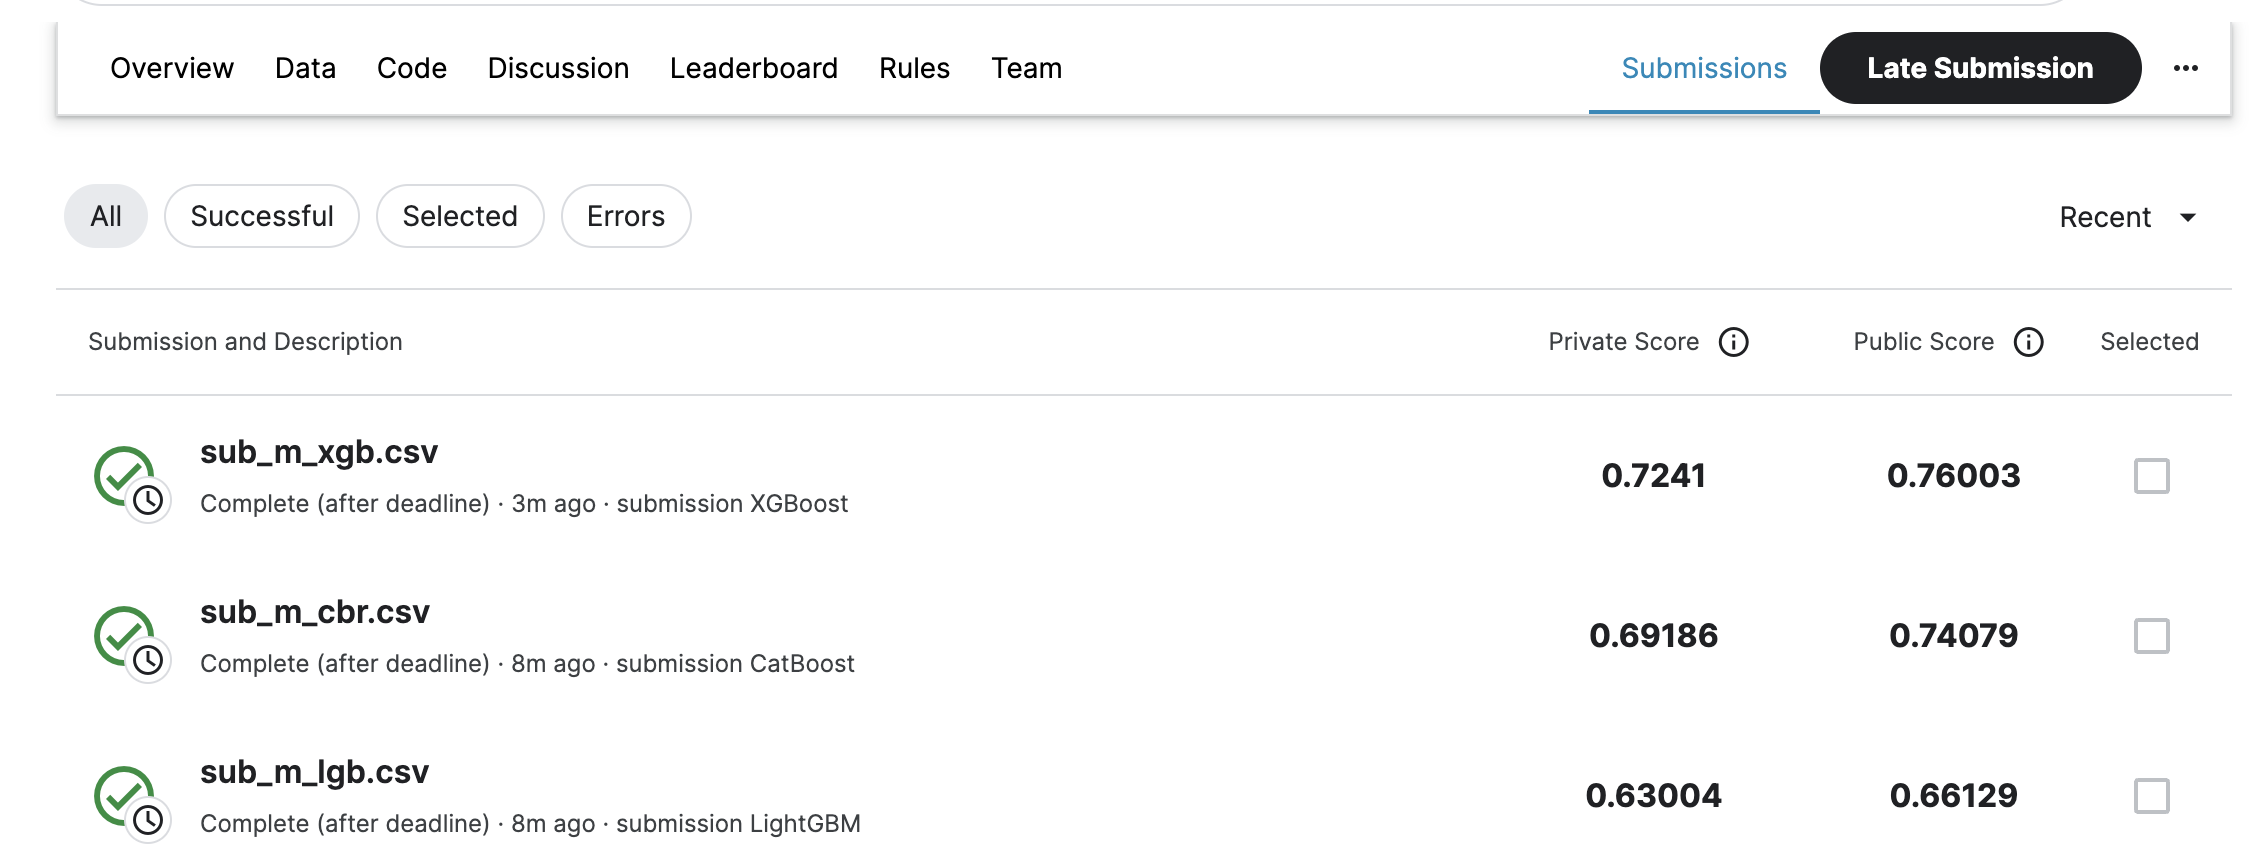